In [1]:
from datetime import datetime

import corner
import emcee
import numpy as np

import itm.cosmology
from itm.posterior_calculator import PosteriorCalculator
import itm.utils

In [2]:
experiments = [
    'local_hubble',
    'cosmic_chronometers',
    'jla',
    'bao_compilation',
    'bao_wigglez'
]
# LCDM
# p0 = [24.96, 0.69, 0.022, 0.12]
# cosmo = itm.cosmology.LCDM()

#wCDM
p0 = [24.96, 0.69, 0.022, 0.12, -0.99]
cosmo = itm.cosmology.WCDM()

max_n = 50000

In [3]:
%%time
 
config_params = itm.utils.load_config("/Users/fabio/code/fchibana/tachyons/config.yaml")
mcmc_params = config_params["mcmc_params"]


ndim = len(p0)  
nwalkers =  mcmc_params["n_walkers"] 
out_name = "results/" + datetime.now().strftime("%Y%m%d_%H%M%S")

backend = emcee.backends.HDFBackend(out_name + ".h5")
backend.reset(nwalkers, ndim)


# MCMC =============================================================================================
print("walkers: ", nwalkers)
prob = PosteriorCalculator(cosmology = cosmo,
                           experiments=experiments)
sampler = emcee.EnsembleSampler(nwalkers, ndim, prob.ln_posterior, backend=backend)

# condicoes iniciais dos walkers dentro da bola de centro p1_0
pos = [p0 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
for sample in sampler.sample(pos, iterations=max_n, progress=True):
    # Only check convergence every 100 steps
    steps = sampler.iteration
    if sampler.iteration % 100:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    # print(tau)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau

walkers:  32
Loading local_hubble data
Loading cosmic_chronometers data
Loading jla data
Loading bao_compilation data
Loading bao_wigglez data


 22%|██▏       | 11100/50000 [1:52:09<6:33:04,  1.65it/s]

CPU times: user 3h 3min 46s, sys: 19min 7s, total: 3h 22min 53s
Wall time: 1h 52min 10s


In [4]:
# Analysis ===========================================================================================
tau = sampler.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
flat_samples = sampler.get_chain(discard=burnin, flat=True, thin=thin)

In [5]:
# flat_samples = sampler.get_chain(flat=True)
# print(flat_samples.shape)

In [6]:
# fig = corner.corner(flat_samples,
#                     labels=["M", "$h$",
#                             "$\Omega_{b} h^2$", "$\Omega_{c} h^2$"],
#                     quantiles=(0.16, 0.5, 0.84), show_titles=True,
#                     title_kwargs={"fontsize": 12})
# fig.suptitle('walkers: %s steps: %s' % (nwalkers, steps))
# # fig = corner.corner(flat_samples)
# # fig.show()

# fig.savefig(out_name + ".png")


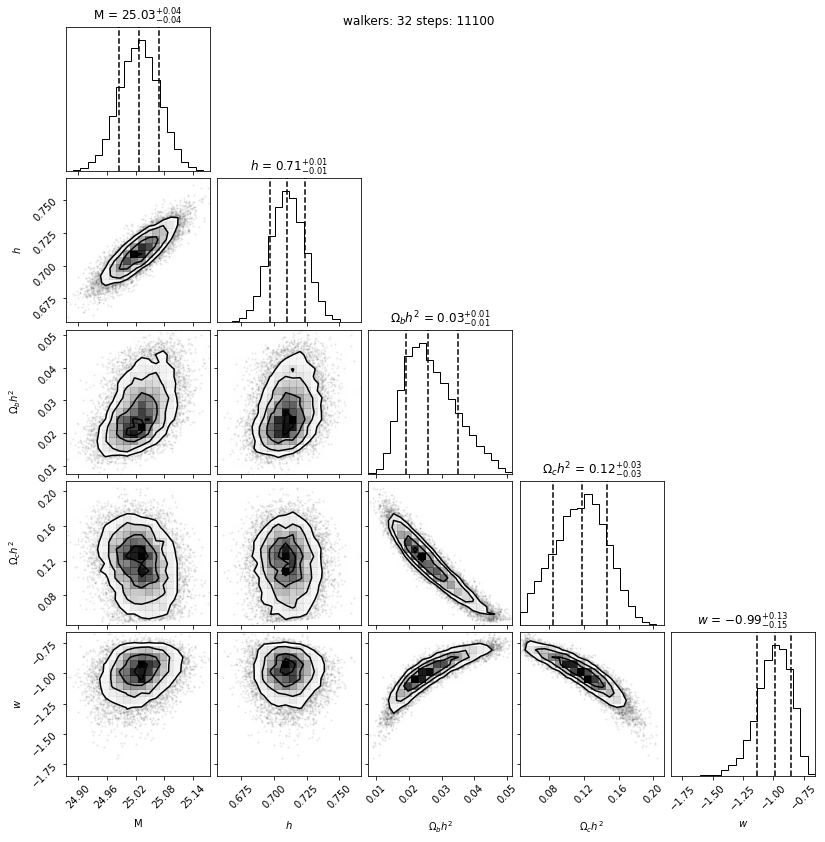

In [7]:
fig = corner.corner(flat_samples,
                    labels=["M", "$h$",
                            "$\Omega_{b} h^2$", "$\Omega_{c} h^2$",
                            "$w$"],
                    quantiles=(0.16, 0.5, 0.84), show_titles=True,
                    title_kwargs={"fontsize": 12})
fig.suptitle('walkers: %s steps: %s' % (nwalkers, steps))
# fig = corner.corner(flat_samples)
# fig.show()

fig.savefig(out_name + ".png")